In [ ]:
!pip install psychrnn

In [ ]:
from psychrnn.backend.models.basic import Basic
from psychrnn.tasks.task import Task

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

from scipy.io import loadmat
import glob
import os
import pickle
from datetime import datetime
import shutil

%matplotlib inline

In [ ]:
class DelayedMatchToCategory(Task):
    """ Multidirectional decision-making task.

    On each trial the network receives input from units representing different locations on a ring. Each input unit magnitude represents closeness to the angle of input. The network must determine which side of arbitrary category boundaries the input belongs to and respond accordingly.

    Takes :attr:`N_in` channels of noisy input arranged in a ring with gaussian signal around the ring centered at 0 at the stimulus angle.
    :attr:`N_out` channel output arranged as slices of a ring with a one hot encoding towards the correct category output based on the angular location of the gaussian input bump.

    Loosely based on `Freedman, David J., and John A. Assad. "Experience-dependent representation of visual categories in parietal cortex." Nature 443.7107 (2006): 85-88. <https://www.nature.com/articles/nature05078>`_

    Args:
        dt (float): The simulation timestep.
        tau (float): The intrinsic time constant of neural state decay.
        T (float): The trial length.
        N_batch (int): The number of trials per training update.
        N_in (int, optional): The number of network inputs. Defaults to 16.
        N_out (int, optional): The number of network outputs. Defaults to 2.

    """

    def __init__(self, dt, tau, T, N_batch, task_params_dict, N_in=16, N_out=2):
        super(DelayedMatchToCategory,self).__init__(N_in, N_out, dt, tau, T, N_batch)
        self.task_params_dict = task_params_dict

    def _gaussian_input(self,angle, scale = 1):
        """ Calculates angular gaussian pdf with mean at the :data:`angle` for N_in evenly arranged around the circumference of a unit circle.

        Args:
            angle (float): The angle on the input circle at which to center the gaussian.
            scale (float, optional): The scale of the gaussian function. Defaults to 1.

        Returns:
            ndarray(dtype=float, shape=(:attr:`N_in`,)): Normal pdf value at (angle - angle of N_in channel).

        """

        g = np.zeros(self.N_in)
        map_g = np.linspace(0,2*np.pi,self.N_in)
        for ii in range(self.N_in):

            # Center N_in around angle, and truncate so -pi <= effective angle <= pi
            effective_angle = map_g[ii] - angle
            if effective_angle > np.pi:
                effective_angle = -2*np.pi + effective_angle
            elif effective_angle < -np.pi:
                effective_angle = 2*np.pi + effective_angle

            x = effective_angle/scale

            g[ii] = np.exp(-x**2/2.0) / (np.sqrt(2*np.pi)*scale)
        return g


    def generate_trial_params(self, batch, trial):
        """Define parameters for each trial.

        Implements :func:`~psychrnn.tasks.task.Task.generate_trial_params`.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch *batch*.

        Returns:
            dict: Dictionary of trial parameters including the following keys:

            :Dictionary Keys:
                * **angle** (*float*) -- Angle at which to center the gaussian. Randomly selected.
                * **category** (*int*) -- Index of the N_out category channel that contains the :data:`angle`.
                * **onset_time** (*float*) -- Stimulus onset time. Set to 200.
                * **input_dur** (*float*) -- Stimulus duration. Set to 1000.
                * **output_dur** (*float*) -- Output duration. The time given to make a choice. Set to 800.
                * **stim_noise** (*float*) -- Scales the stimlus noise. Set to .1.

        """
        # params = dict()
        params = self.task_params_dict

        params['angle1'] = 2*np.pi*np.random.rand()
        params['angle2'] = 2*np.pi*np.random.rand()
        params['category1'] = int(params['angle1']/(2*np.pi/self.N_out))
        params['category2'] = int(params['angle2']/(2*np.pi/self.N_out))
        # params['angle'] = 2*np.pi*np.random.rand()
        # params['category'] = int(params['angle']/(2*np.pi/self.N_out))

        params['stim1_end_time'] = params['stim1_onset_time'] + params['stim1_duration']

        params['stim2_onset_time'] = params['stim1_end_time'] + params['delay_between_stimuli']
        params['stim2_end_time'] = params['stim2_onset_time'] + params['stim2_duration']

        params['decision_time_onset'] = params['stim2_end_time'] + params['delay_before_decision_time']
        params['decision_time_end'] = params['decision_time_onset'] + params['decision_time_duration']

        return params

    def trial_function(self, t, params):
        """Compute the trial properties at :data:`time`.

        Implements :func:`~psychrnn.tasks.task.Task.trial_function`.

        Based on the :data:`params` compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at :data:`time`.

        Args:
            time (int): The time within the trial (0 <= :data:`time` < :attr:`T`).
            params (dict): The trial params produced by :func:`generate_trial_params`.

        Returns:
            tuple:

            * **x_t** (*ndarray(dtype=float, shape=(*:attr:`N_in` *,))*) -- Trial input at :data:`time` given :data:`params`. For ``params['onset_time'] < time < params['onset_time'] + params['input_dur']`` , gaussian pdf with mean = angle and scale = 1 is added to each input channel based on the channel's angle.
            * **y_t** (*ndarray(dtype=float, shape=(*:attr:`N_out` *,))*) -- Correct trial output at :data:`time` given :data:`params`. 1 in the :data:`params['category']` output channel during the output period defined by :data:`params['output_dur']`, 0 otherwise.
            * **mask_t** (*ndarray(dtype=bool, shape=(*:attr:`N_out` *,))*) -- True if the network should train to match the y_t, False if the network should ignore y_t when training. True during the output period, False otherwise.

        """
        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = (1./(2*self.dt))*params['stim_noise']*np.random.randn(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.zeros(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        stim1_onset_time = params['stim1_onset_time']
        stim1_end_time = params['stim1_end_time']
        stim2_onset_time = params['stim2_onset_time']
        stim2_end_time = params['stim2_end_time']

        decision_time_onset = params['decision_time_onset']
        decision_time_end = params['decision_time_end']

        angle1 = params['angle1']
        category1 = params['category1']
        angle2 = params['angle2']
        category2 = params['category2']
        # angle = params['angle']
        # category = params['category']

        # Determine output category
        # if stim_1_category == stim_2_category: category = 0
        # else: category = 1
        if params['category1'] == params['category2']: category = 0
        else: category = 1


        if stim1_onset_time <= t < stim1_end_time:
            x_t += self._gaussian_input(angle1)

        if stim2_onset_time <= t < stim2_end_time:
            x_t += self._gaussian_input(angle2)

        if decision_time_onset <= t < decision_time_end:
            y_t[category] += 1.
            mask_t = np.ones(self.N_out)

        return x_t, y_t, mask_t

    def accuracy_function(self, correct_output, test_output, output_mask):
        """Calculates the accuracy of :data:`test_output`.

        Implements :func:`~psychrnn.tasks.task.Task.accuracy_function`.

        Takes the channel-wise mean of the masked output for each trial. Whichever channel has a greater mean is considered to be the network's "choice".

        Returns:
            float: 0 <= accuracy <= 1. Accuracy is equal to the ratio of trials in which the network made the correct choice as defined above.

        """
        chosen = np.argmax(np.mean(test_output*output_mask, axis=1), axis = 1)
        truth = np.argmax(np.mean(correct_output*output_mask, axis = 1), axis = 1)
        return np.mean(np.equal(truth, chosen))


# Pulled out of the class above for testing
def gaussian_input(angle, N_in=16, scale = 1):
        """ Calculates angular gaussian pdf with mean at the :data:`angle` for N_in evenly arranged around the circumference of a unit circle.

        Args:
            angle (float): The angle on the input circle at which to center the gaussian.
            scale (float, optional): The scale of the gaussian function. Defaults to 1.

        Returns:
            ndarray(dtype=float, shape=(:attr:`N_in`,)): Normal pdf value at (angle - angle of N_in channel).

        """

        g = np.zeros(N_in)
        map_g = np.linspace(0,2*np.pi,N_in)
        for ii in range(N_in):

            # Center N_in around angle, and truncate so -pi <= effective angle <= pi
            effective_angle = map_g[ii] - angle
            if effective_angle > np.pi:
                effective_angle = -2*np.pi + effective_angle
            elif effective_angle < -np.pi:
                effective_angle = 2*np.pi + effective_angle

            x = effective_angle/scale

            g[ii] = np.exp(-x**2/2.0) / (np.sqrt(2*np.pi)*scale)
        return g

In [ ]:
seed=2020

tf.compat.v2.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
LOAD_MODEL_FROM_FILE = True
WEIGHTS_FILENAME = "final_weights.npz"
# WEIGHTS_FILENAME = "weights1000.npz"
DATA_FILENAME = 'RNN_data_21-13-19_23-07-2023.pkl'

params = {}
params['stim1_onset_time'] = 200
params['stim1_duration'] = 200
params['delay_between_stimuli'] = 500 # delay between samples
params['delay_before_decision_time'] = 500 # delay between second stimuli and decision time
params['stim2_duration'] = 200
params['decision_time_duration'] = 800
params['stim_noise'] = 0.1

total_T = params['stim1_onset_time'] + params['stim1_duration'] + params['delay_between_stimuli'] + params['stim2_duration'] + params['delay_before_decision_time'] + params['decision_time_duration']

In [ ]:
dt = 10 # The simulation timestep.
tau = 100 # The intrinsic time constant of neural state decay.
T = total_T # The trial length.
N_batch = 50 # The number of trials per training update.
N_rec = 50 # The number of recurrent units in the network.
name = 'basicModel' #  Unique name used to determine variable scope for internal use.

params['dt'] = dt
params['tau'] = tau
params['T'] = T
params['N_batch'] = N_batch
params['N_rec'] = N_rec
params['name'] = name

In [ ]:
dmc = DelayedMatchToCategory(dt = dt, tau = tau, T = T, N_batch = N_batch, task_params_dict = params) # Initialize the task object

In [ ]:
network_params = dmc.get_task_params()
print(network_params)

{'N_batch': 50, 'N_in': 16, 'N_out': 2, 'dt': 10, 'tau': 100, 'T': 2400, 'alpha': 0.1, 'N_steps': 240, 'task_params_dict': {'stim1_onset_time': 200, 'stim1_duration': 200, 'delay_between_stimuli': 500, 'delay_before_decision_time': 500, 'stim2_duration': 200, 'decision_time_duration': 800, 'stim_noise': 0.1, 'dt': 10, 'tau': 100, 'T': 2400, 'N_batch': 50, 'N_rec': 50, 'name': 'basicModel'}}


In [ ]:
params = dmc.generate_trial_params(0,0)
x_t, y_t, mask_t = dmc.trial_function(0,params)
print(x_t.shape, y_t.shape, mask_t.shape)

(16,) (2,) (2,)


In [ ]:
network_params['name'] = name # Unique name used to determine variable scope.
network_params['N_rec'] = N_rec # The number of recurrent units in the network.

network_params['rec_noise'] = 0.0 # Noise into each recurrent unit. Default: 0.0
network_params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
network_params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
network_params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
network_params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
network_params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
network_params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True

network_params['transfer_function'] = tf.nn.relu # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".

network_params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
# network_params['initializer'] = # Initializer to use for the network. Default: WeightInitializer (network_params) if network_params includes W_rec or load_weights_path as a key, GaussianSpectralRadius (network_params) otherwise.

In [ ]:
try:
  basicModel.destruct()
except:
  print('NO MODEL INSTANCE EXISTS')

In [ ]:
if LOAD_MODEL_FROM_FILE:
  with open(DATA_FILENAME, 'rb') as f:
      trained_RNN_data = pickle.load(f)

In [ ]:
if LOAD_MODEL_FROM_FILE:
  file_network_params = network_params.copy()
  file_network_params['name'] = 'file'
  file_network_params['load_weights_path'] = f'./{WEIGHTS_FILENAME}'

In [ ]:
if LOAD_MODEL_FROM_FILE: basicModel = Basic(file_network_params)
else: basicModel = Basic(network_params)

TRAINING

In [ ]:
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 100000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = 0.001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = 'weights' # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['optimizer_name'] = 'Adam'
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

train_params['fixed_weights'] = None # Dictionary of weights to fix (not allow to train). Default: None

train_params['performance_cutoff'] = None # If performance_measure is not None, training stops as soon as performance_measure surpases the performance_cutoff. Default: None.
train_params['performance_measure'] = None # Function to calculate the performance of the network using custom criteria. Default: None.]

In [ ]:
if not LOAD_MODEL_FROM_FILE:
  # with tf.device('/device:CPU:0'):
  losses, initialTime, trainTime = basicModel.train(dmc, train_params)
else:
  losses = trained_RNN_data['losses']

In [ ]:
if not LOAD_MODEL_FROM_FILE: basicModel.save("./final_weights")

Text(0.5, 1.0, 'Loss During Training')

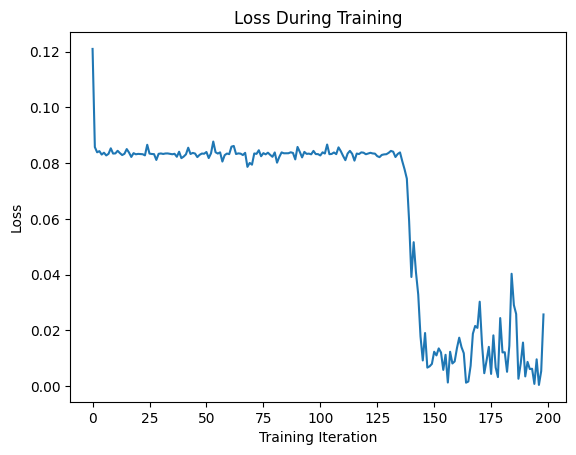

In [ ]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

In [ ]:
x,y,m, _ = dmc.get_trial_batch()

Text(0.5, 1.0, 'Input Data')

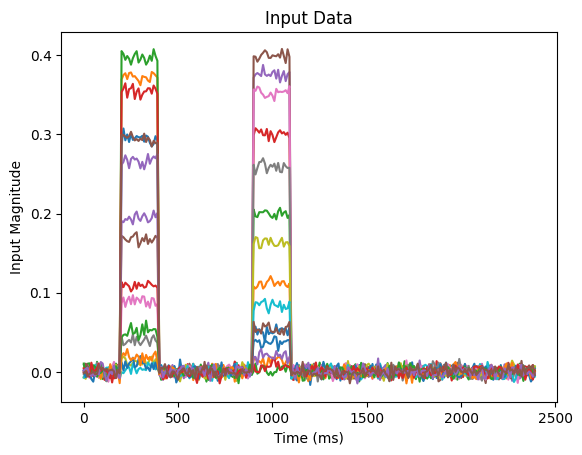

In [ ]:
plt.plot(range(0, len(x[0,:,:])*dt,dt), x[0,:,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data")

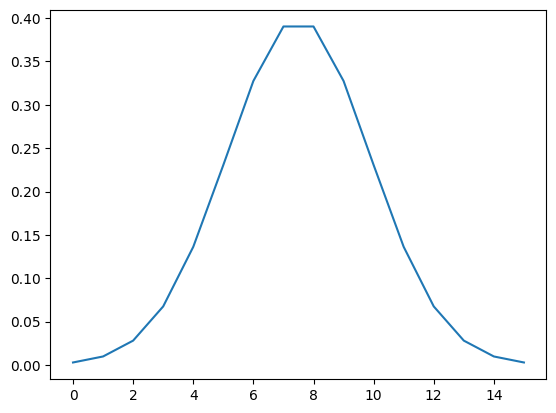

In [ ]:
plt.plot(gaussian_input(np.pi))

In [ ]:
output, state_var = basicModel.test(x)

Text(0.5, 1.0, 'label')

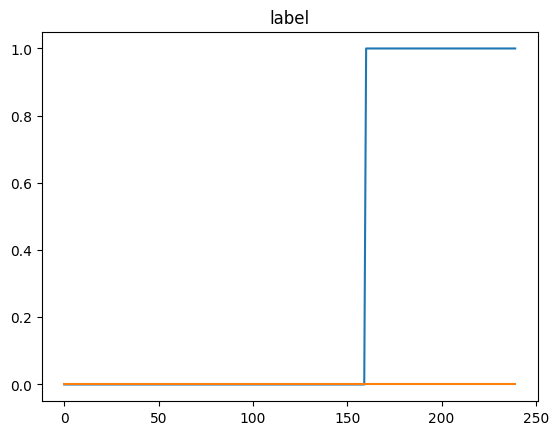

In [ ]:
plt.plot(y[40,:,:])
plt.title('label')

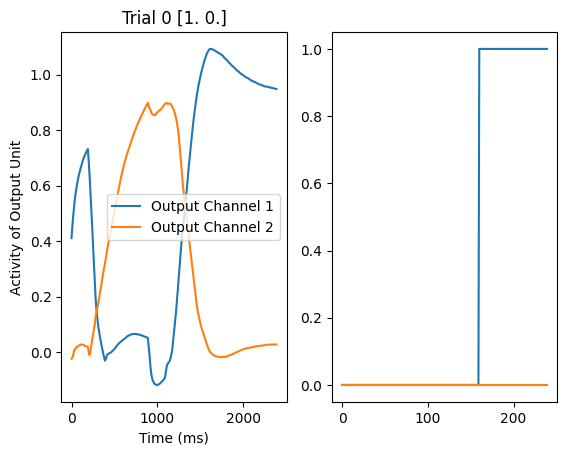

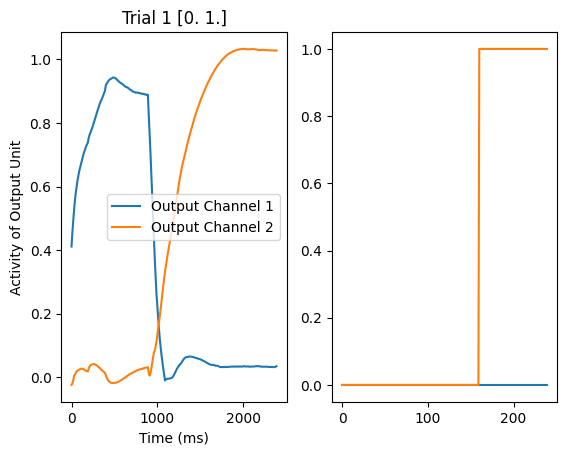

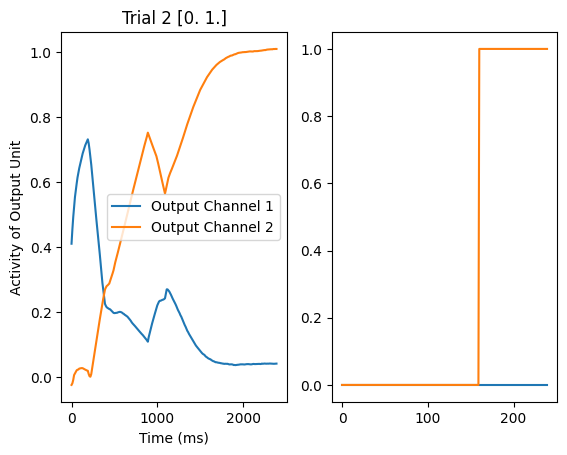

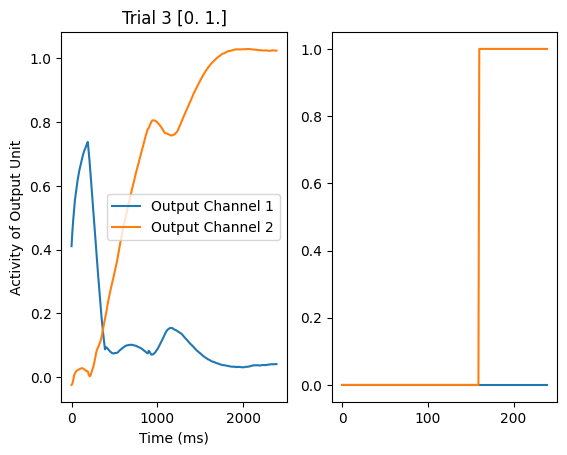

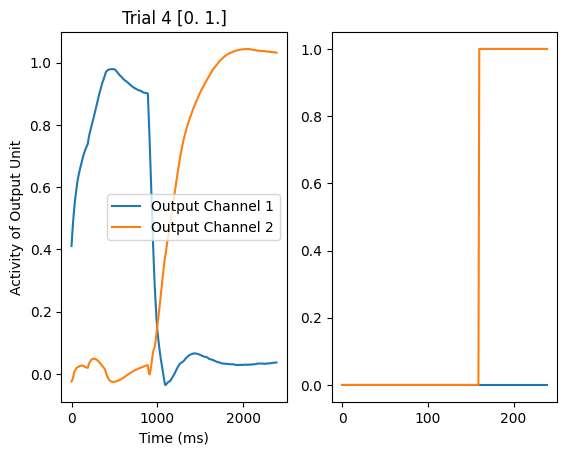

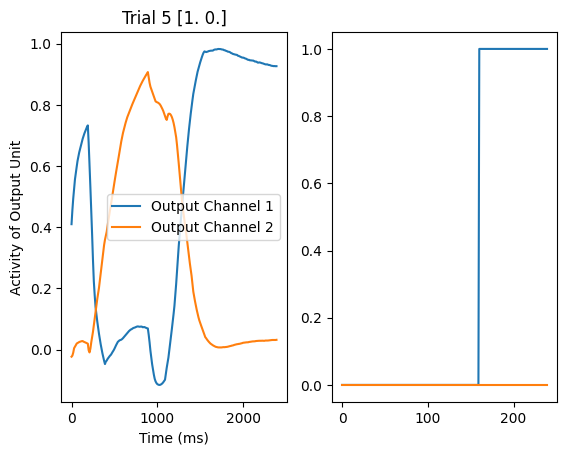

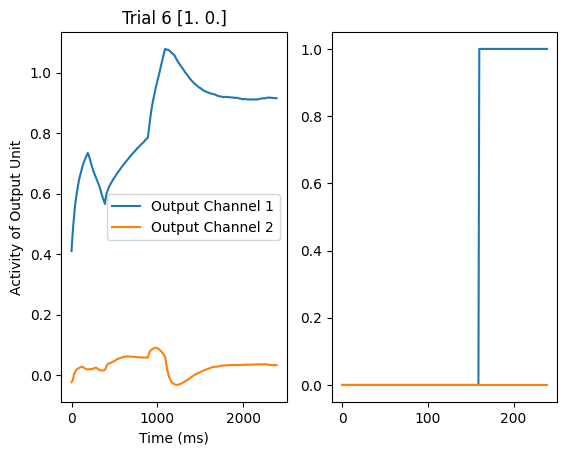

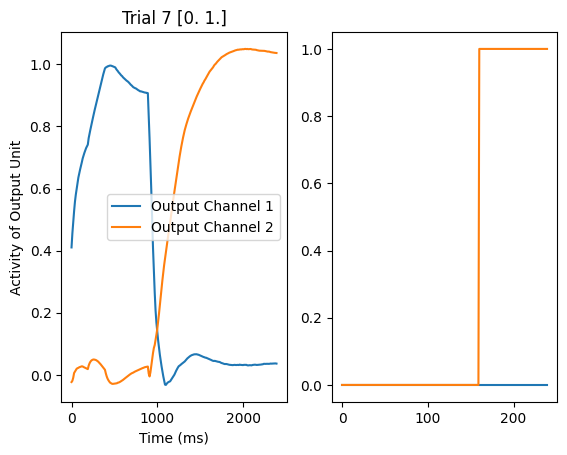

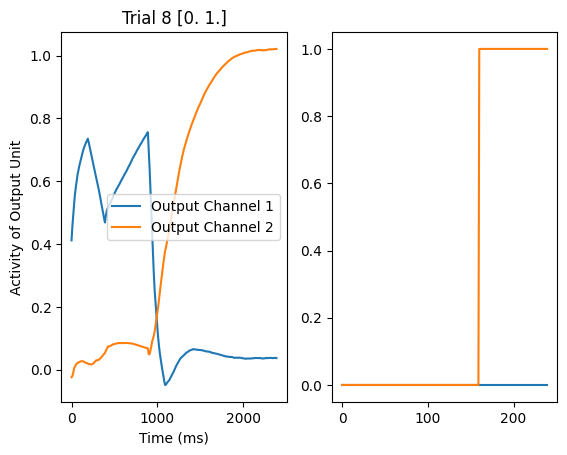

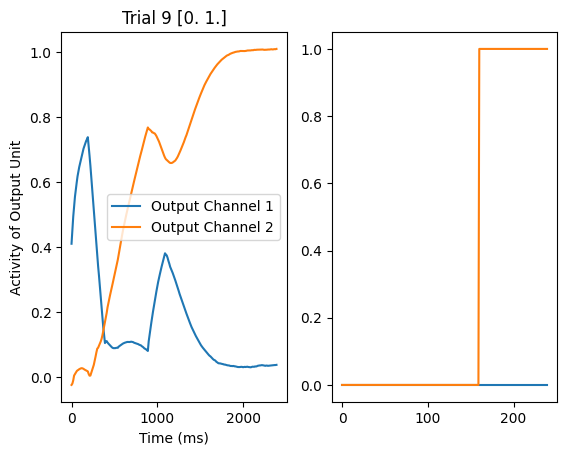

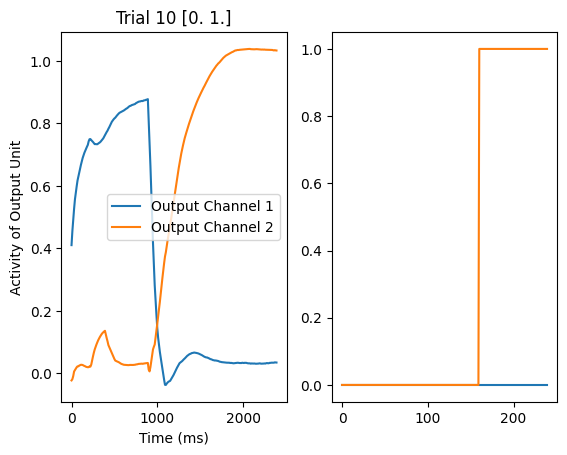

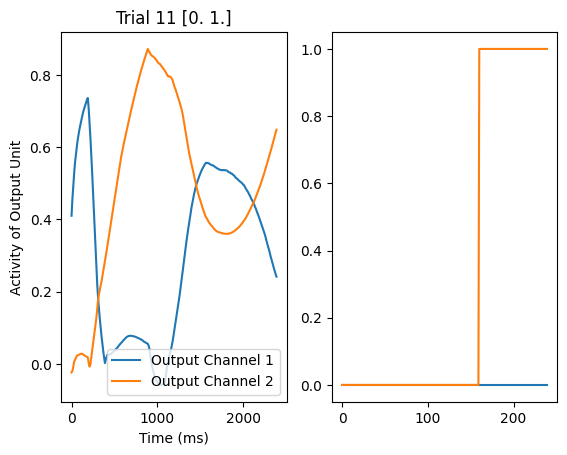

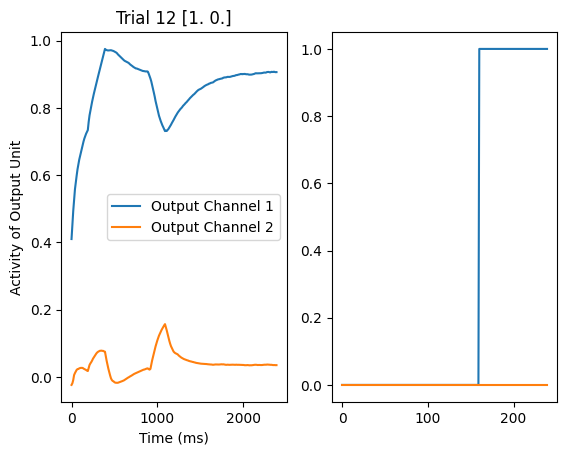

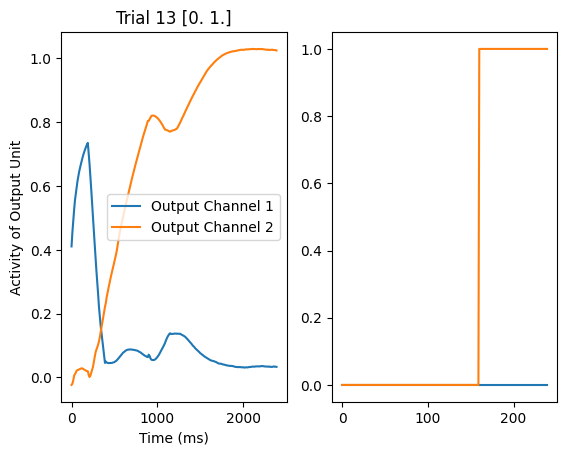

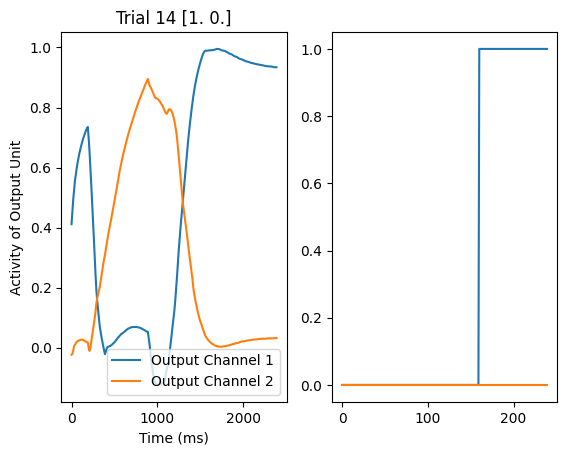

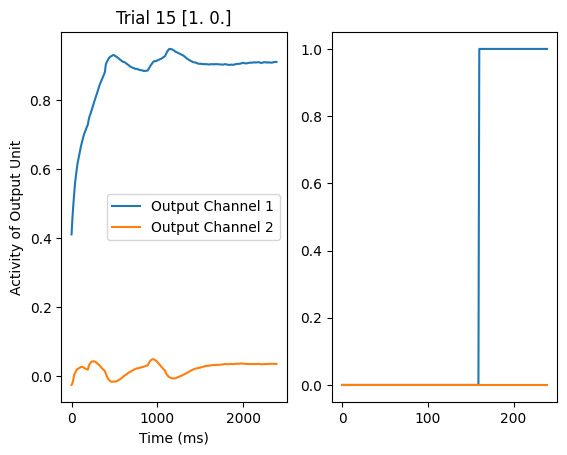

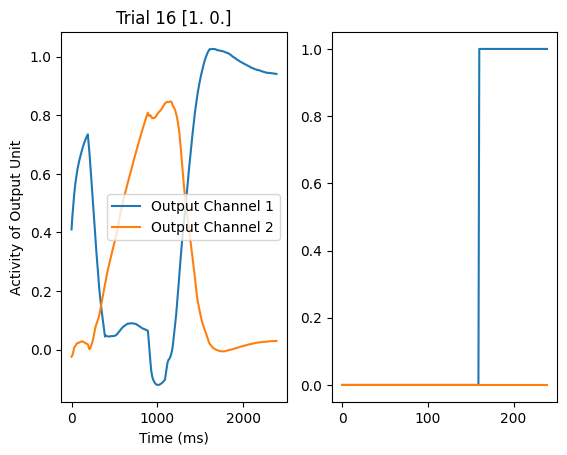

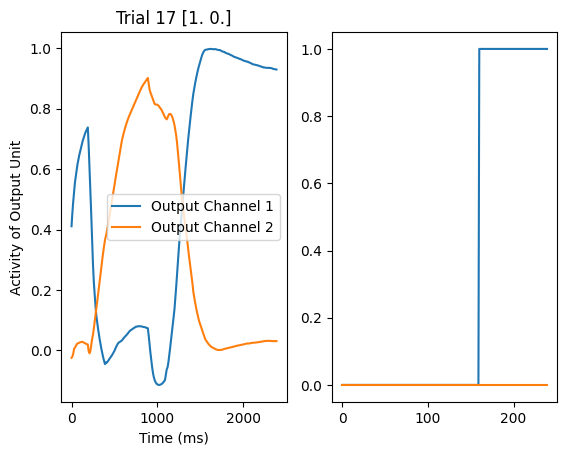

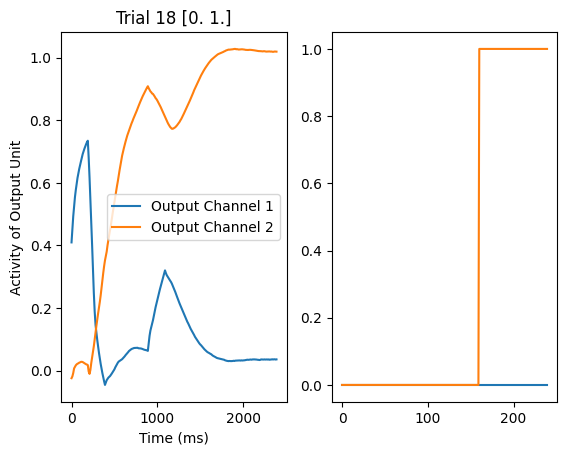

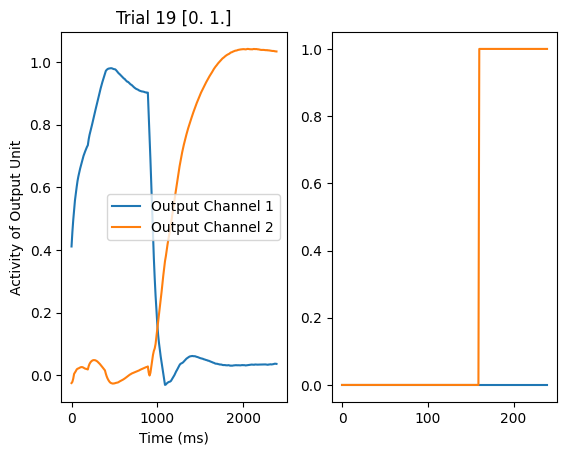

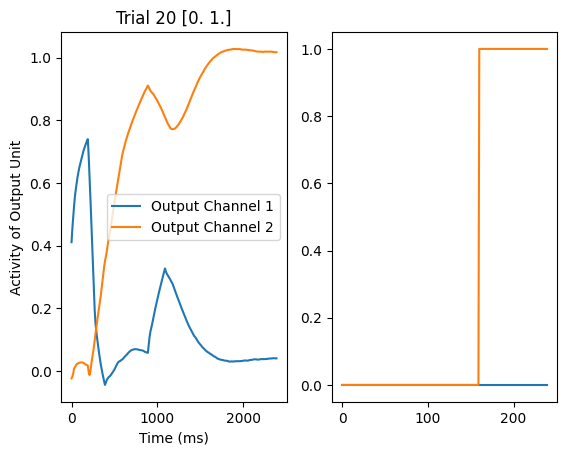

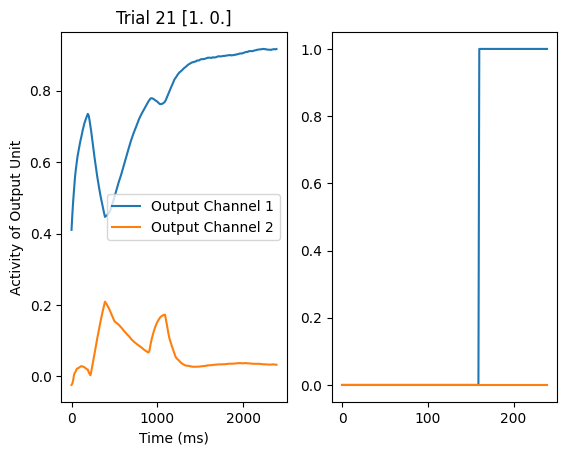

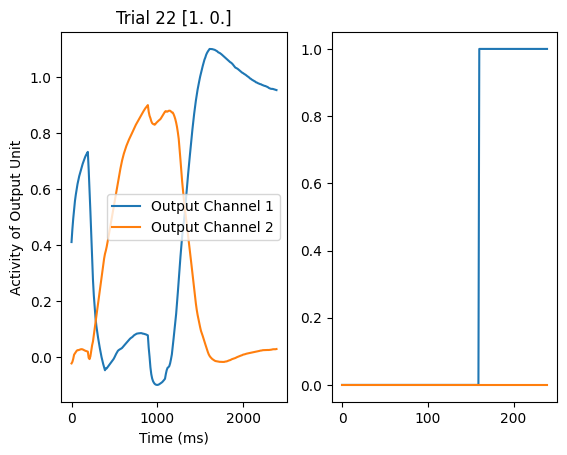

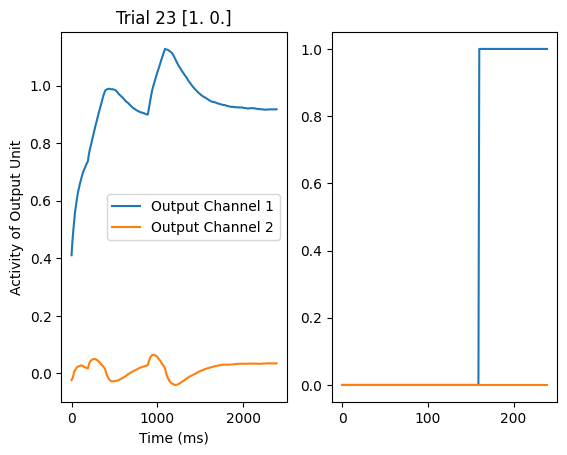

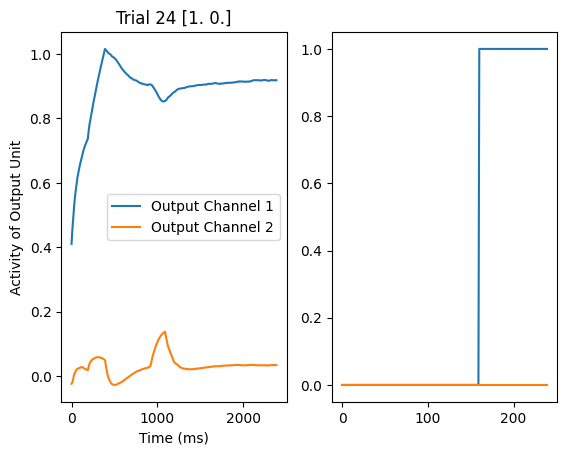

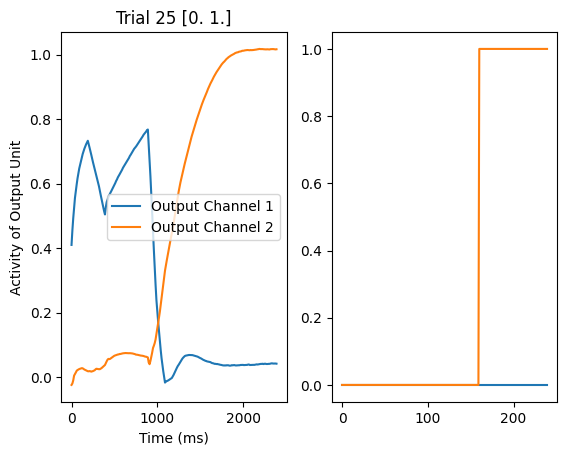

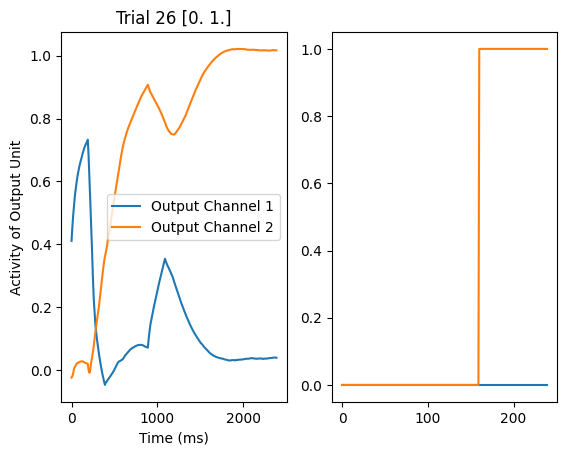

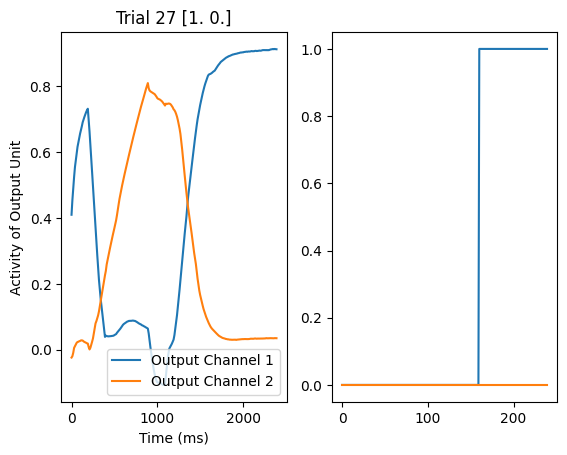

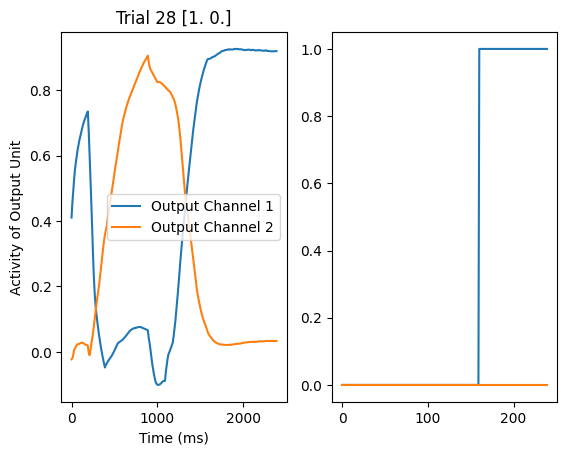

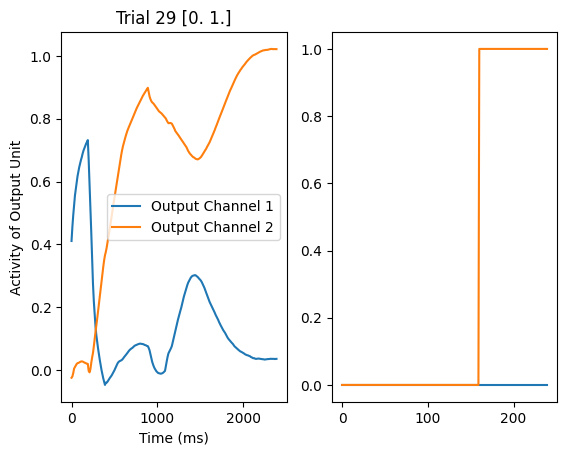

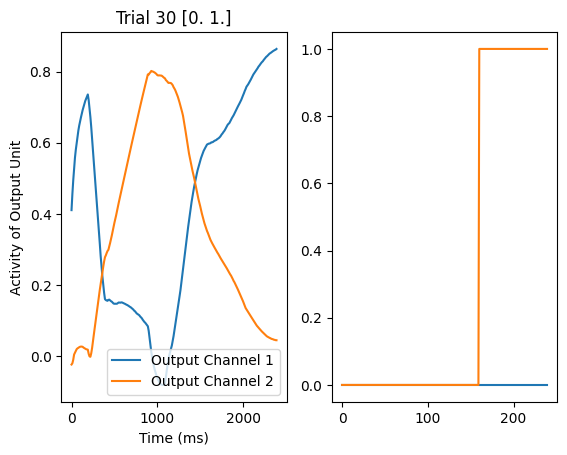

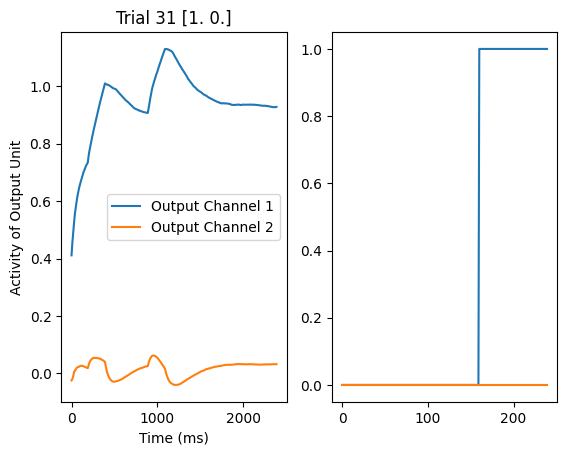

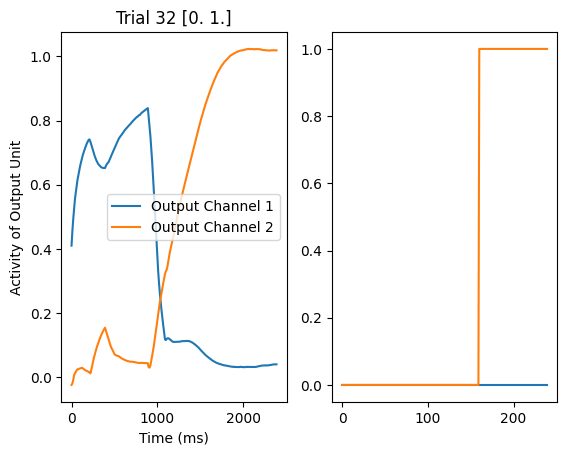

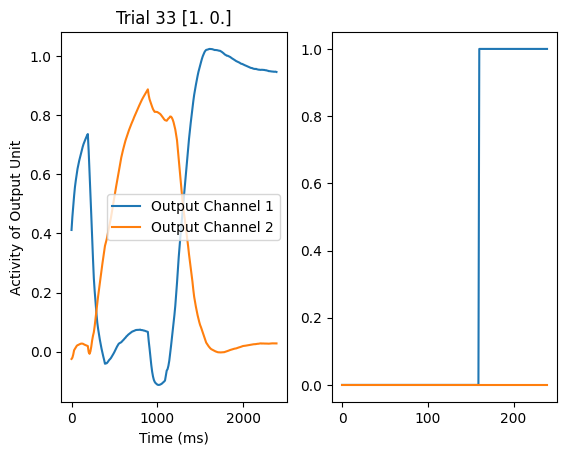

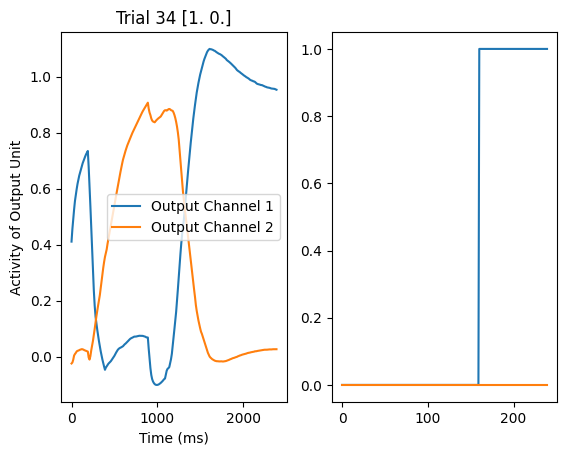

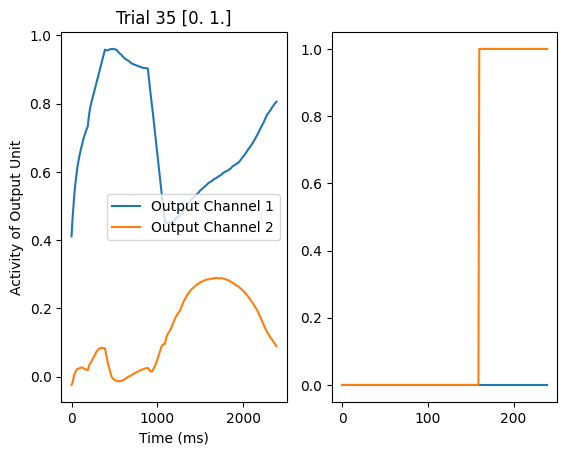

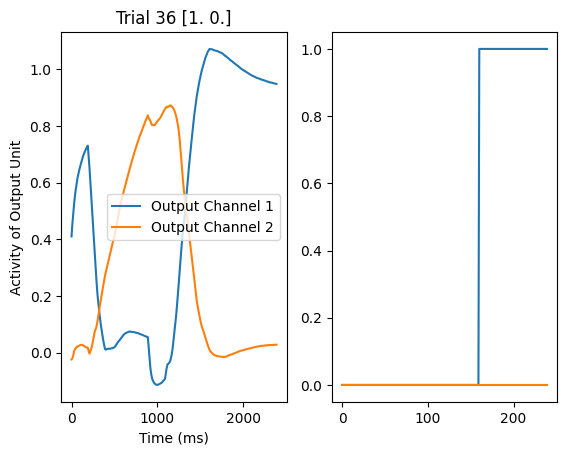

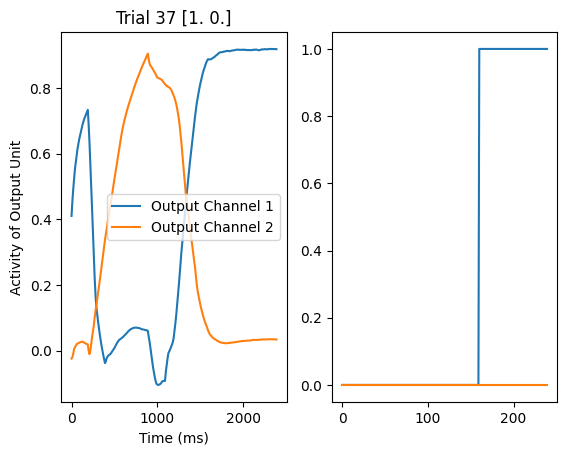

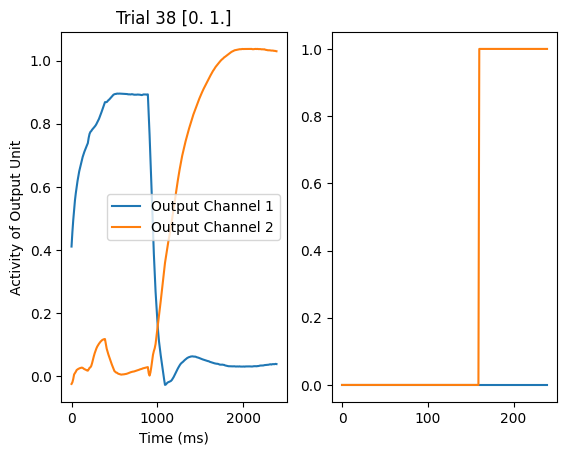

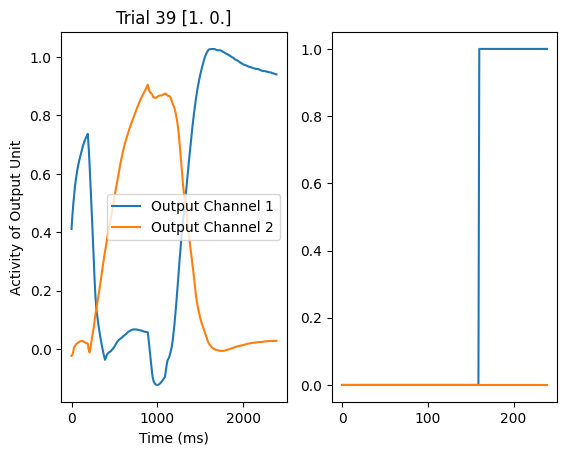

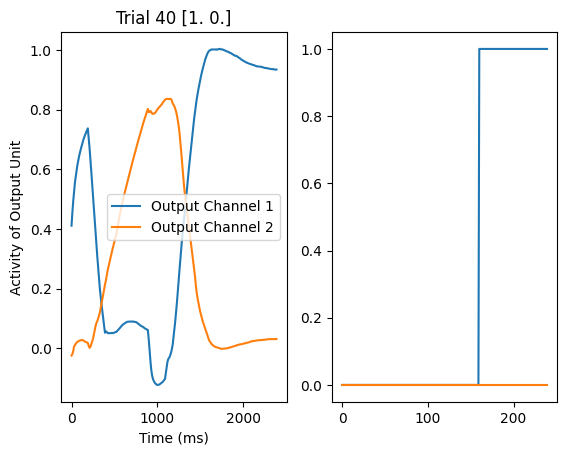

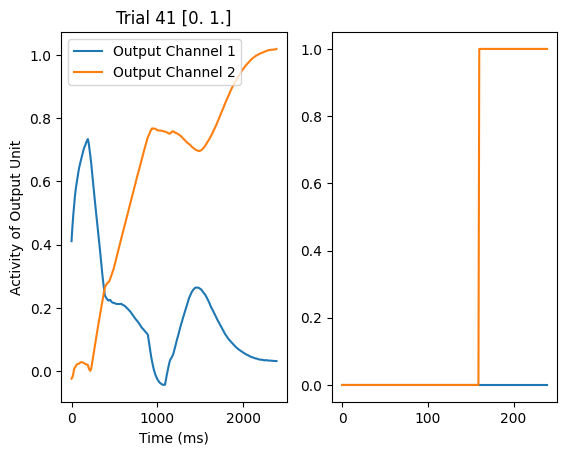

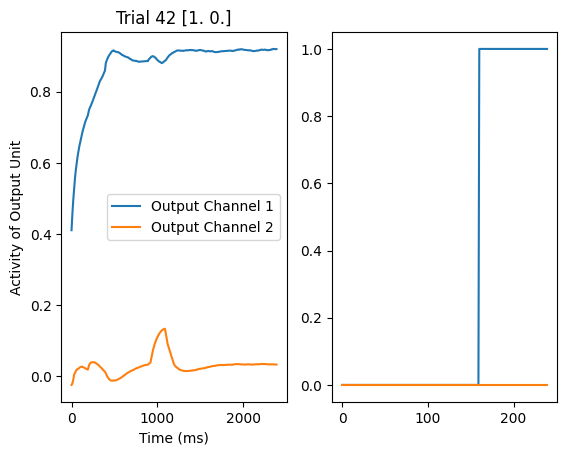

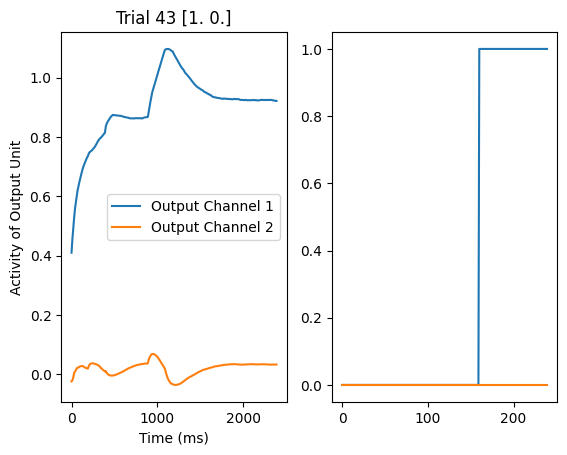

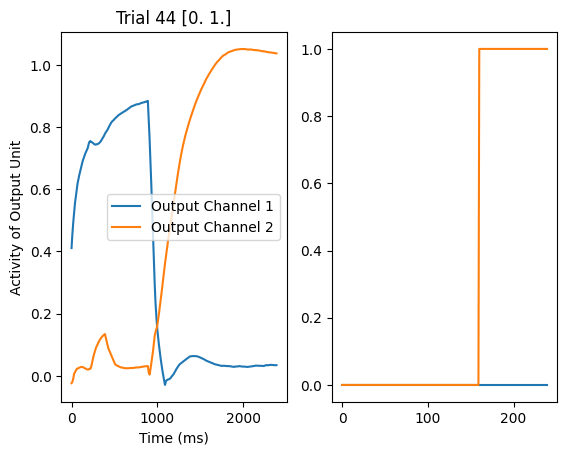

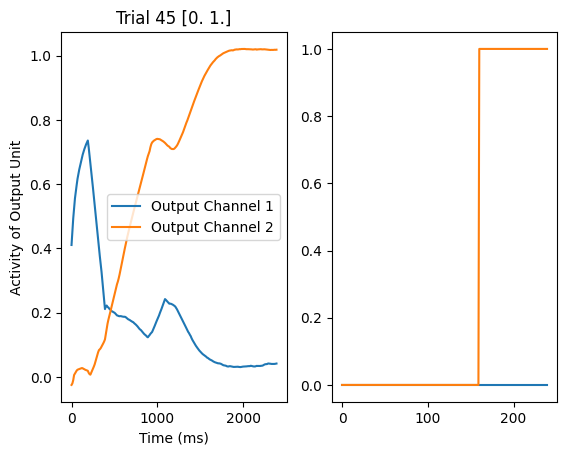

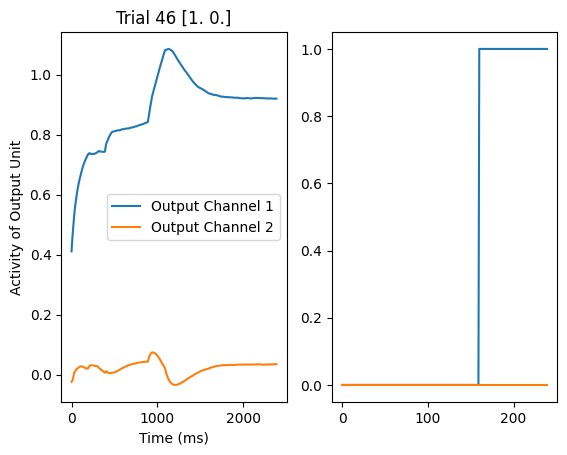

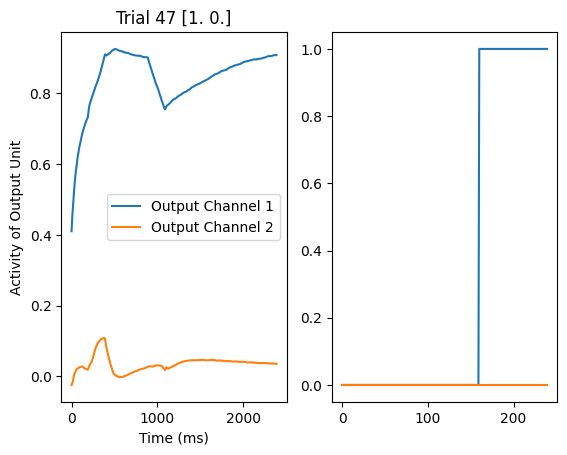

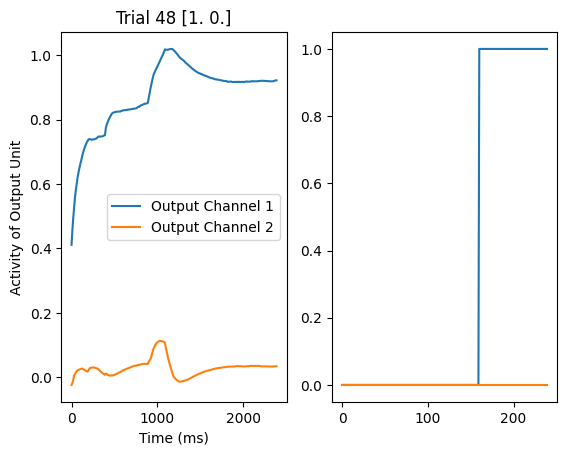

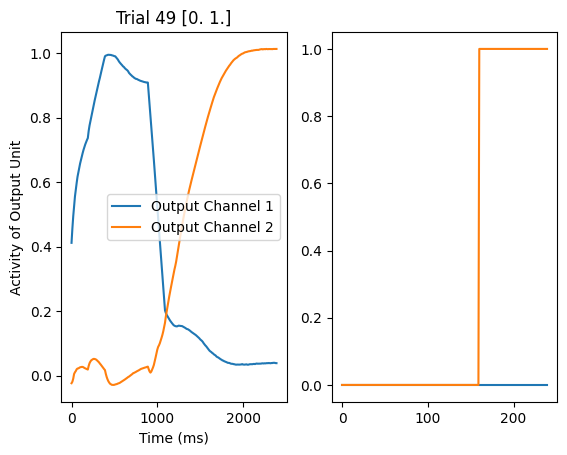

In [ ]:
for trial in range(50):
  fig,ax = plt.subplots(ncols=2,nrows=1)
  ax[0].plot(range(0, len(output[0,:,:])*dt,dt),output[trial,:,:])
  ax[0].set_ylabel("Activity of Output Unit")
  ax[0].set_xlabel("Time (ms)")
  ax[0].set_title(f"Trial {trial} {y[trial,-1]}")
  ax[0].legend(["Output Channel 1", "Output Channel 2"])

  ax[1].plot(range(0, len(y[0,:,:])), y[trial,:,:])

  plt.show()

In [ ]:
dmc.accuracy_function(y, output, m)

0.94

In [ ]:
match_trials = 0
non_match_trials = 0
for i in range(N_batch):
  if y[i,-1,0]==1: match_trials+=1
  else: non_match_trials+=1
print('match_trials',100*match_trials/N_batch,'% of total')
print('non_match_trials',100*non_match_trials/N_batch,'% of total')

match_trials 52.0 % of total
non_match_trials 48.0 % of total


In [ ]:
"""
predictions (tf.Tensor(dtype=float, shape =(N_batch, N_steps, N_out ))) – Network output.
y (tf.Tensor(dtype=float, shape =(?, N_steps, N_out ))) – Target output.
output_mask (tf.Tensor(dtype=float, shape =(?, N_steps, N_out ))) – Output mask
"""

trial = -1
loss = np.nanmean(m[trial] * -(y[trial] * np.log(output[trial]) + (1-y[trial])* np.log(1-output[trial])))
print(loss)

0.01579949548127266


<ipython-input-84-d6e42cd0e9e3>:8: RuntimeWarning: invalid value encountered in log
  loss = np.nanmean(m[trial] * -(y[trial] * np.log(output[trial]) + (1-y[trial])* np.log(1-output[trial])))


Text(0.5, 1.0, 'Evolution of State Variables over Time')

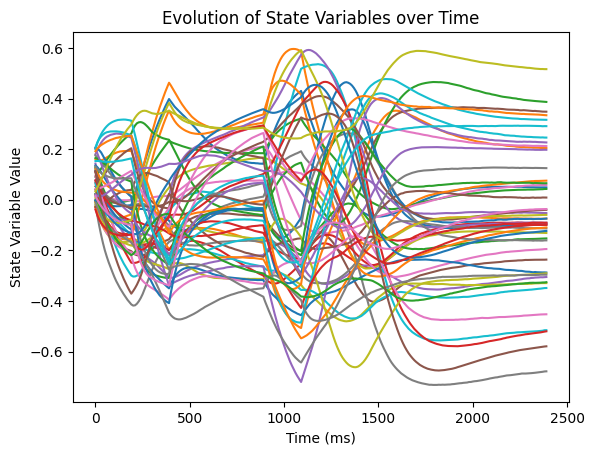

In [ ]:
plt.plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

In [ ]:
#double-check the accuracy for plotting
rnn_tmm = 0
rnn_fmm = 0
rnn_tm = 0
rnn_fm = 0
for i in range(50):
  if output[i][-1][0] < output[i][-1][1] and y[i][-1][0] < y[i][-1][1]:
    rnn_tmm += 1
  elif output[i][-1][0] > output[i][-1][1] and y[i][-1][0] > y[i][-1][1]:
    rnn_tm += 1
  elif output[i][-1][0] > output[i][-1][1] and y[i][-1][0] < y[i][-1][1]:
    rnn_fmm += 1
  elif output[i][-1][0] < output[i][-1][1] and y[i][-1][0] > y[i][-1][1]:
    rnn_fm += 1

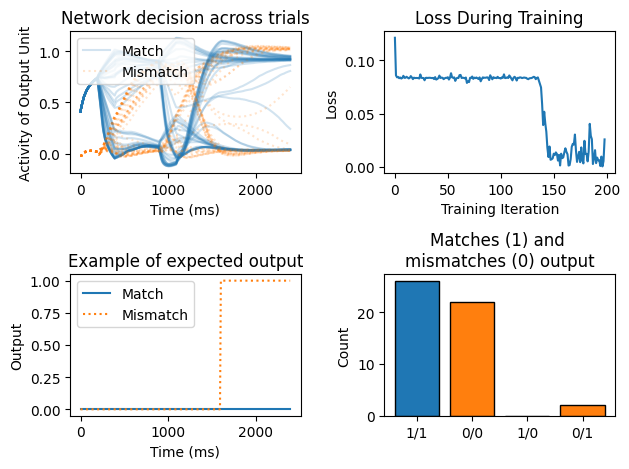

In [ ]:
bfig,ax = plt.subplots(ncols=2,nrows=2)
color = ['C1', 'C2'] * 50
for i in range(50):
  ax[0,0].plot(range(0, len(output[i,:,0])*dt,dt),output[i,:,0], color = 'C0', alpha = 0.2)
  ax[0,0].plot(range(0, len(output[i,:,1])*dt,dt),output[i,:,1], color = 'C1', alpha = 0.2, linestyle='dotted')
ax[0,0].set_ylabel("Activity of Output Unit")
ax[0,0].set_xlabel("Time (ms)")
ax[0,0].legend(["Match", "Mismatch"], loc = 2)
ax[0,0].set_title('Network decision across trials')

ax[0,1].plot(losses)
ax[0,1].set_ylabel("Loss")
ax[0,1].set_xlabel("Training Iteration")
ax[0,1].set_title("Loss During Training")

# for i in range(50):
ax[1,0].plot(range(0, len(y[0,:,0])*dt,dt),y[i,:,0], color = 'C0')
ax[1,0].plot(range(0, len(y[0,:,1])*dt,dt),y[i,:,1], color = 'C1', linestyle='dotted')
ax[1,0].set_ylabel("Output")
ax[1,0].set_xlabel("Time (ms)")
ax[1,0].legend(["Match", "Mismatch"], loc = 2)
ax[1,0].set_title('Example of expected output')

ax[1,1].bar(x = np.linspace(1,4,4), height = [rnn_tm, rnn_tmm, rnn_fm, rnn_fmm],
            color = ['C0', 'C1', 'C0', 'C1'], edgecolor = 'black')
ax[1,1].set_xticks(np.linspace(1,4,4), labels = ['1/1', '0/0', '1/0', '0/1'])
ax[1,1].set_ylabel("Count")
ax[1,1].set_title('Matches (1) and \nmismatches (0) output')

plt.tight_layout()
plt.show()

Saving task parameters and activity

In [ ]:
trial_batch_generator = dmc.batch_generator()
# can also use x_t,y_t,mastk_t,task_parameters = dmc.get_trial_batch()

In [ ]:
next(trial_batch_generator)[0].shape # x_t

(50, 240, 16)

In [ ]:
next(trial_batch_generator)[1].shape # y_t

(50, 240, 2)

In [ ]:
next(trial_batch_generator)[2].shape # mask_t

(50, 240, 2)

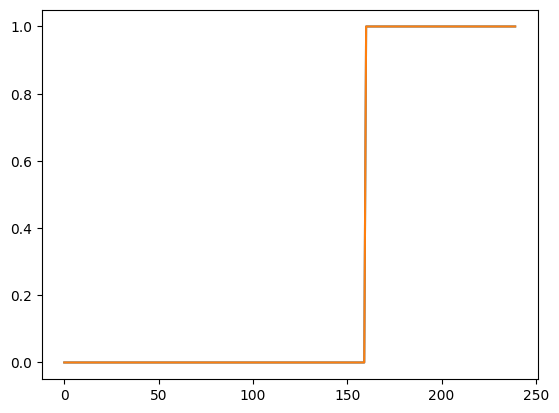

In [ ]:
# plt.plot(next(trial_batch_generator)[2][0,:,0])
plt.plot(next(trial_batch_generator)[2][0,:,:])

In [ ]:
print(next(trial_batch_generator)[3].shape)
next(trial_batch_generator)[3][0]

(50,)


{'stim1_onset_time': 200,
 'stim1_duration': 200,
 'delay_between_stimuli': 500,
 'delay_before_decision_time': 500,
 'stim2_duration': 200,
 'decision_time_duration': 800,
 'stim_noise': 0.1,
 'dt': 10,
 'tau': 100,
 'T': 2400,
 'N_batch': 50,
 'N_rec': 50,
 'name': 'basicModel',
 'angle1': 4.104576567506328,
 'angle2': 3.8584866005601497,
 'category1': 1,
 'category2': 1,
 'stim1_end_time': 400,
 'stim2_onset_time': 900,
 'stim2_end_time': 1100,
 'decision_time_onset': 1600,
 'decision_time_end': 2400}

In [ ]:
datetime_now = datetime.now().strftime("%H-%M-%S_%d-%m-%Y")

In [ ]:
parameters_and_activity_to_save = {}

new_task_data_generated = next(trial_batch_generator)

parameters_and_activity_to_save['x_t'] = new_task_data_generated[0]
parameters_and_activity_to_save['y_t'] = new_task_data_generated[1]
parameters_and_activity_to_save['mask_t'] = new_task_data_generated[2]
parameters_and_activity_to_save['task_parameters'] = new_task_data_generated[3]
parameters_and_activity_to_save['losses'] = losses

parameters_and_activity_to_save['network_params'] = network_params
tr_pr = train_params.copy()
tr_pr['optimizer'] = tr_pr['optimizer_name']
parameters_and_activity_to_save['train_params'] = tr_pr

In [ ]:
# NOT DOING THIS -> archiving all weight files and saving separately

# weights_dict = {}

# weights_save_epoch = train_params['save_training_weights_epoch']
# for i in range(weights_save_epoch*50, train_params['training_iters'], weights_save_epoch*50):
#   # print(i)
#   # print(i//50)
#   f = np.load(f'weights{i//50}.npz', allow_pickle=True)
#   weights_dict[f'{i//50}_iter_{i}'] = {name: f[name] for name in f.files}
# parameters_and_activity_to_save['weights'] = weights_dict

# f = np.load('saved_weights.npz', allow_pickle=True)
# parameters_and_activity_to_save['final_weights'] = {name: f[name] for name in f.files}

# # How to save and load npz files
# # f = np.load('filename.npz')
# # arrays_to_save = {name: f[name] for name in f.files}
# # np.savez('new_file.npz', **arrays_to_save)


if not os.path.exists('./model_weights'): os.makedirs('./model_weights')
weights_save_epoch = train_params['save_training_weights_epoch']
for i in range(weights_save_epoch*50, train_params['training_iters'], weights_save_epoch*50):
    shutil.move(f"./weights{i//50}.npz", f"./model_weights/weights{i//50}.npz")
shutil.move(f"./final_weights.npz", f"./model_weights/final_weights.npz")
shutil.make_archive(f'model_weights_{datetime_now}', 'zip', 'model_weights')

FileNotFoundError: ignored

In [ ]:
# Record activity of RNN

output_units_activity, hidden_units_activity = basicModel.test(parameters_and_activity_to_save['x_t'])

In [ ]:
hidden_units_activity.shape

In [ ]:
parameters_and_activity_to_save['output_units_activity'] = output_units_activity
parameters_and_activity_to_save['hidden_units_activity'] = hidden_units_activity

parameters_and_activity_to_save['final_accuracy'] = dmc.accuracy_function(parameters_and_activity_to_save['y_t'], parameters_and_activity_to_save['output_units_activity'], parameters_and_activity_to_save['mask_t'])

In [ ]:
parameters_and_activity_to_save.keys()

In [ ]:
# Save everything into a pickle file

with open(f'RNN_data_{datetime_now}.pkl', 'wb') as fff:
    pickle.dump(parameters_and_activity_to_save, fff)